TLDR : in this notebook we compare the photometry of the same objects by the same pipeline at different epochs. Of course, some objects could be inherently variable, but the majority of objects isn not.

### Table of contents : <a id='toc'></a>

[Step1  Find and process visits at different epochs](#step1)

[Step2  Use the visit info to compare different epochs](#step2)

### Necessary Imports

In [1]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs
import astropy.io.votable as vo
from astroML.stats._point_statistics import sigmaG

## Find and process visits at same location but different epochs <a id='step1'></a>

[Jump to top](#toc)

Given the fields that we already processed with LSST, could there be any other one that I could process that was taken at a similar location  ?


In [146]:
#visit_density_dic = {'20':[611529,609754,525814,525900],
#                     '15':[611970,525837,525838],
#                     '10':[611969,525846,525879],
#                     '5':[525904,525920]}  

# These are the high-density fields that already got processed,
# and don't have yet a pair ... 
visit_density_dic =  {'1': [644144, 644273],
                      '3': [567795, 644082],
                      '5': [567283, 644074, 527064],
                      '7': [526028, 641548], 
                      '10': [527453, 641497, 611969]}
densities = [1,1,3,3,5,5,5,7,7,10,10,10]
visit  = [644144, 644273,567795, 644082,567283, 644074, 527064,526028, 641548,
         527453, 641497, 611969]

visit_info = Table(data = [visit,densities], names=['visit', 'density'])

# Use the DECAPS-MAF cross-matched information table 
# from N0 
decaps_maf = Table.read('decapsIMDB_MAF_table', format='ascii')

# join on visits 
visits = join(decaps_maf, visit_info, keys='visit')

# sort by density
visits.sort('density')

In [174]:
# Nnow find out if there are any other visits than the 
# ones above at  roughly the same location , and 
# definitely the same filter and exptime 

decaps = decaps_maf.copy()
# Now cross-match the info table for fields that already got 
# processed with LSST against the entire rest of the imbd ...

# First, remove the 12 visits that we already processed so that 
# they wouldn't be matched to self ....
decaps_else = decaps[np.bitwise_not(np.in1d(decaps['visit'], visits['visit']))]
choose_filter=  decaps_else['filterid'] == 'g.0000'
choose_exp = decaps_else['exptime'] > 90
decaps_ = decaps_else[choose_filter*choose_exp]



In [175]:
# Next, match by coords
# express pixel coordinates as SkyCoord object, 
decaps_coords = SkyCoord(decaps_['ra'],decaps_['dec'], frame='icrs', 
                         unit='degree')

# express the decaps field coordinates as SkyCoord object ..
visits_coords = SkyCoord(ra = visits['ra'].data, dec = visits['dec'].data, 
                       unit='degree', frame='icrs')

idx, d2d, d3d = visits_coords.match_to_catalog_sky(decaps_coords)  

# stack the two catalogs 
stack_imdb = hstack([visits, decaps_[idx]])



In [176]:
# add column with distance to the nearest MAF pixel...
stack_imdb['d2d_deg'] = d2d.degree

# add a column with separation between visits in days 
stack_imdb['dmjd'] = stack_imdb['mjd_obs_1'] -stack_imdb['mjd_obs_2']

mask_d = stack_imdb['d2d_deg'] < 0.3
mask_exp1 = stack_imdb['exptime_1'] > 90
mask  = mask_d * mask_exp1

visit_info = stack_imdb[mask]


In [180]:
visit_info

visit_1,prodtype_1,exptime_1,mjd_obs_1,filterid_1,ra_1,dec_1,sb_name_1,magzero_1,catfname_1,dtnsanam_1,source_density_1,ra_rad_1,dec_rad_1,N_px_greater_1,frac_greater_1,d2d_deg_1,density,visit_2,prodtype_2,exptime_2,mjd_obs_2,filterid_2,ra_2,dec_2,sb_name_2,magzero_2,catfname_2,dtnsanam_2,source_density_2,ra_rad_2,dec_rad_2,N_px_greater_2,frac_greater_2,d2d_deg_2,d2d_deg,dmjd
int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,float64,float64,float64,float64,float64,float64,float64
644144,image,96.0,57871.2390682,g.0000,243.0753,-53.37272,c4d_170428_054642_ori.fits,28.336,c4d_170428_054642_ooi_g_v1.cat.fits,c4d_170428_054642_ooi_g_v1,1292976.0,4.24756149592,-0.9350118584,674.0,0.01737830033,0.264616337096,1,566793,image,96.0,57624.0491755,g.0000,243.0826,-53.3718,c4d_160824_011313_ooi_g_v1.fits,29.645,c4d_160824_011313_ooi_g_v1.cat.fits,c4d_160824_011313_ori.fits,1292976.0,4.24756149592,-0.9350118584,674.0,0.01737830033,0.26248559718,0.00445138750958,247.1898927
644273,image,96.0,57871.3768262,g.0000,263.4564,-26.02691,c4d_170428_090504_ori.fits,26.626,c4d_170428_090504_ooi_g_v1.cat.fits,c4d_170428_090504_ooi_g_v1,1834416.0,4.60194236366,-0.452816594745,443.0,0.0114222359736,0.210501813112,1,644852,image,96.0,57872.3380472,g.0000,263.7749,-26.03337,c4d_170429_080914_ori.fits,26.691,c4d_170429_080914_ooi_g_v1.cat.fits,c4d_170429_080914_ooi_g_v1,1834416.0,4.60194236366,-0.452816594745,443.0,0.0114222359736,0.128364803638,0.286265245288,-0.961220969999
567795,image,96.0,57626.1594579,g.0000,252.1502,-47.42566,c4d_160826_035203_ooi_g_v1.fits,29.313,c4d_160826_035203_ooi_g_v1.cat.fits,c4d_160826_035203_ori.fits,721728.0,4.395473932,-0.826545631034,1313.0,0.0338541666667,0.219405767955,3,644205,image,96.0,57871.3047269,g.0000,251.8074,-47.41331,c4d_170428_072115_ori.fits,28.125,c4d_170428_072115_ooi_g_v1.cat.fits,c4d_170428_072115_ooi_g_v1,721728.0,4.395473932,-0.826545631034,1313.0,0.0338541666667,0.0604846429564,0.232275620862,-245.14526893
644082,image,96.0,57871.1576248,g.0000,190.3052,-61.0924,c4d_170428_034923_ori.fits,28.417,c4d_170428_034923_ooi_g_v1.cat.fits,c4d_170428_034923_ooi_g_v1,783324.0,3.3228383836,-1.06796306462,1182.0,0.0304764851485,0.104648645281,3,527555,image,96.0,57464.3369168,g.0000,190.315,-61.0927,c4d_160317_080735_ooi_g_v1.fits,28.684,c4d_160317_080735_ooi_g_v1.cat.fits,c4d_160317_080735_ori.fits,783324.0,3.3228383836,-1.06796306462,1182.0,0.0304764851485,0.102726636554,0.00474677249647,406.82070794
527064,image,96.0,57463.2848345,g.0000,189.8903,-59.43301,c4d_160316_065235_ooi_g_v1.fits,30.055,c4d_160316_065235_ooi_g_v1.cat.fits,c4d_160316_065235_ori.fits,591336.0,3.31399712848,-1.0415738425,1626.0,0.0419245049505,0.244853930329,5,527552,image,96.0,57464.3333061,g.0000,189.8847,-59.42771,c4d_160317_080227_ooi_g_v1.fits,29.069,c4d_160317_080227_ooi_g_v1.cat.fits,c4d_160317_080227_ori.fits,591336.0,3.31399712848,-1.0415738425,1626.0,0.0419245049505,0.250097938522,0.00601677196678,-1.0484716
567283,image,96.0,57625.0883125,g.0000,247.0427,-47.27046,c4d_160825_020935_ooi_g_v1.fits,29.551,c4d_160825_020935_ooi_g_v1.cat.fits,c4d_160825_020935_ori.fits,612648.0,4.31280044111,-0.826545631034,1553.0,0.0400422854785,0.096893761328,5,645255,image,96.0,57873.2392276,g.0000,247.0343,-47.2701,c4d_170430_054653_ori.fits,27.907,c4d_170430_054653_ooi_g_v1.cat.fits,c4d_170430_054653_ooi_g_v1,612648.0,4.31280044111,-0.826545631034,1553.0,0.0400422854785,0.0998340127795,0.00571110023097,-248.15091507
644074,image,96.0,57871.1475844,g.0000,188.4872,-67.27576,c4d_170428_033458_ori.fits,29.002,c4d_170428_033458_ooi_g_v1.cat.fits,c4d_170428_033458_ooi_g_v1,481788.0,3.26826977672,-1.17268186594,1987.0,0.0512324669967,0.483371912045,5,644070,image,96.0,57871.1432634,g.0000,188.1755,-67.22559,c4d_170428_032844_ori.fits,28.99,c4d_170428_032844_ooi_g_v1.cat.fits,c4d_170428_0328

In [183]:
visit_info[['density', 'visit_2','catfname_2', 'frac_greater_2',
            'visit_1', 'dmjd', 'd2d_deg' ]]

density,visit_2,catfname_2,frac_greater_2,visit_1,dmjd,d2d_deg
int64,int64,str35,float64,int64,float64,float64
1,566793,c4d_160824_011313_ooi_g_v1.cat.fits,0.01737830033,644144,247.1898927,0.00445138750958
1,644852,c4d_170429_080914_ooi_g_v1.cat.fits,0.0114222359736,644273,-0.961220969999,0.286265245288
3,644205,c4d_170428_072115_ooi_g_v1.cat.fits,0.0338541666667,567795,-245.14526893,0.232275620862
3,527555,c4d_160317_080735_ooi_g_v1.cat.fits,0.0304764851485,644082,406.82070794,0.00474677249647
5,527552,c4d_160317_080227_ooi_g_v1.cat.fits,0.0419245049505,527064,-1.0484716,0.00601677196678
5,645255,c4d_170430_054653_ooi_g_v1.cat.fits,0.0400422854785,567283,-248.15091507,0.00571110023097
5,644070,c4d_170428_032844_ooi_g_v1.cat.fits,0.0512324669967,644074,0.00432097000157,0.130558523793
7,641500,c4d_170421_015828_ooi_g_v1.cat.fits,0.0767584570957,526028,-402.83866125,0.0026389447085
7,644011,c4d_170428_015126_ooi_g_v1.cat.fits,0.0669348184818,641548,-6.93600583,0.140919701827


In [202]:
x = len('c4d_160824_011313')
s = 'ingestImagesDecam.py repo/ noao_files/instcal/'
cmd = [s+line[:x]+'*' for line in visit_info['catfname_2']]
np.savetxt('cmd.txt',cmd, fmt='%s')

In [200]:
np.savetxt?

In [184]:
visit_info.write('decaps_rms_different_epoch_fields2.txt', format='ascii',
                 overwrite=True)



Ok, found 8 pairs, two per density, of fields that were observed at different but close epochs.

For the new fields I found 12 pairs, i.e. another visit that was at the same location as 12 already observed ones, but not necessarily very close in time . Does it matter that the obs are spaced by little in time ?  Here they are in the same location, but separated for some by over a year.... Perhaps not enough movement to notice any difference in a year ? 

Need to save the ones we want as a votable ...

Output of two queries : 
    
    SELECT *  FROM voi.siap WHERE dtpropid ILIKE '%2016A-0327%' AND proctype = 'InstCal' LIMIT 50000
    
that yields 11538 rows,  and 

    SELECT reference, release_date, start_date, dtacqnam,filter, exposure, dtnsanam, prodtype, filesize, dtpropid, md5sum  FROM voi.siap WHERE dtpropid ILIKE '%2016B-0279%' AND proctype = 'InstCal' LIMIT 50000
  
that yields 18524 rows, which combined provide me with all DECAPS files in NOAO database (wtmap, dqmask, imaging) . I hstack them to find out the names for all image products required for processing... 

In [ ]:
import astropy.io.votable as vo

# this is the outcome of querying for all from  '%2016A-0327%'
fname1 = 'rows_as_votable_1516932989_6863.vot.xml'  
table1 = vo.parse_single_table(fname1, invalid='mask') 
decaps_rows1 = table1.to_table()

# these are the results of querying for select rows from %2016B-0279% , 
fname2 = 'rows_as_votable_1517705044_1939.vot.xml'
table2 = vo.parse_single_table(fname2, invalid='mask') 
decaps_rows2 = table2.to_table()

print(len(decaps_rows1))
print(len(decaps_rows2))

In [70]:
# Stack with hstack : 
cols = decaps_rows2.colnames
decaps_rows = vstack([decaps_rows1[cols], decaps_rows2])


In [71]:
# Extract the visit number, match by the visit number ...
x1 = len('/data_local/images/DTS/2016A-0327/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in decaps_rows['dtacqnam'].data.astype(str)]
decaps_rows['visit'] = visit

# Extract the full archive fname 
x = len('http://nsaserver.sdm.noao.edu:7003/?fileRef=')
archive = [line[x:] for line in decaps_rows['reference'].data.astype(str)]
decaps_rows['archive_fname'] = archive

# Extract the version number , removing all odd ones in the end...
x = len('v1.fits.fz')
v = [line[-x:-x+2] for line in decaps_rows['archive_fname']]
decaps_rows['version'] = v

In [73]:
# find the rows that are matching ... 
select = np.in1d(decaps_rows['visit'].data.data.astype(str), 
                 stack_imdb[mask]['visit_2'].data.astype(str))


# Display what we have found ... 
# there should be 3*8 = 24 rows ... 
print(decaps_rows[select]['visit','archive_fname', 'prodtype',])


visit            archive_fname            prodtype
------ ---------------------------------- --------
527552 c4d_160317_080227_oow_g_v1.fits.fz    wtmap
527552 c4d_160317_080227_ooi_g_v1.fits.fz    image
527552 c4d_160317_080227_ood_g_v1.fits.fz   dqmask
527555 c4d_160317_080735_oow_g_v1.fits.fz    wtmap
527555 c4d_160317_080735_ooi_g_v1.fits.fz    image
527555 c4d_160317_080735_ood_g_v1.fits.fz   dqmask
566793 c4d_160824_011313_oow_g_v1.fits.fz    wtmap
566793 c4d_160824_011313_ood_g_v1.fits.fz   dqmask
566793 c4d_160824_011313_ooi_g_v1.fits.fz    image
612757 c4d_170125_052727_ood_g_v1.fits.fz   dqmask
   ...                                ...      ...
644070 c4d_170428_032844_oow_g_v1.fits.fz    wtmap
644852 c4d_170429_080914_oow_g_v1.fits.fz    wtmap
644011 c4d_170428_015126_oow_g_v1.fits.fz    wtmap
644035 c4d_170428_022858_ooi_g_v1.fits.fz    image
644011 c4d_170428_015126_ooi_g_v1.fits.fz    image
645255 c4d_170430_054653_oow_g_v1.fits.fz    wtmap
644852 c4d_170429_080914_ood_g_

In [74]:
values, count = np.unique(decaps_rows[select]['visit'], return_counts=True)
for v,c in zip(values, count):
    print(v,c)

527552 3
527555 3
566793 3
612757 5
640995 3
641500 3
644011 3
644035 3
644070 3
644205 3
644852 3
645255 3


For some reason 612757  has more files ... check them out : 

In [75]:
m = decaps_rows[select]['visit'] == '612757'
decaps_rows[select][m]

reference,release_date,start_date,dtacqnam,filter,exposure,dtnsanam,prodtype,filesize,dtpropid,md5sum,visit,archive_fname,version
object,object,object,object,object,float64,object,object,int32,object,object,str6,str34,str2
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ood_g_v1.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ood_g_v1.fits.fz,dqmask,10687680,2016B-0279,6561294c95ca81fec46b7b37caa0576f,612757,c4d_170125_052727_ood_g_v1.fits.fz,v1
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ooi_g_v1.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ooi_g_v1.fits.fz,image,329984640,2016B-0279,695392378914db0eb371ef43bef8b9a5,612757,c4d_170125_052727_ooi_g_v1.fits.fz,v1
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_oow_g_v2.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_oow_g_v2.fits.fz,wtmap,323881920,2016B-0279,23ba9b350dc42c4e82e492dd6994b12b,612757,c4d_170125_052727_oow_g_v2.fits.fz,v2
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ood_g_v2.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ood_g_v2.fits.fz,dqmask,9650880,2016B-0279,f10be717e42bd1d429e893bf3bbe31bb,612757,c4d_170125_052727_ood_g_v2.fits.fz,v2
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ooi_g_v2.fits.fz,2017-01-23,2017-01-24,/data_local/images/DTS/2016B-0279/DECam_00612757.fits.fz,g DECam SDSS c0001 4720.0 1520.0,96.0,c4d_170125_052727_ooi_g_v2.fits.fz,image,335422080,2016B-0279,256cb3883e5767ab575c20674a946176,612757,c4d_170125_052727_ooi_g_v2.fits.fz,v2


Choose only v2 rather than v1 ... 

38

In [95]:
# Remove the unneccessary rows ...
m1 = decaps_rows['visit'] == '612757'
m2  = decaps_rows['version']  == 'v1'
index = np.arange(len(decaps_rows))
print(decaps_rows[m1*m2])
decaps_rows.remove_rows(index[m1*m2])

                                  reference                                    ...
------------------------------------------------------------------------------ ...
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ood_g_v1.fits.fz ...
http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_170125_052727_ooi_g_v1.fits.fz ...


In [100]:
# find the rows that are matching again... ... 
select = np.in1d(decaps_rows['visit'].data.data.astype(str), 
                 stack_imdb[mask]['visit_2'].data.astype(str))

print(np.sum(select))

36


In [101]:

# save that list of archive filenames 
# as a VOTable to download 
# with secure get 
N = np.sum(select)
fname = 'decaps_NOAO_download_votable_'+str(N)+'.vot.xml'
decaps_rows[select].write(fname,format='votable',
                          overwrite=True)
print('We saved %d names to download as %s'%(N,fname))

We saved 36 names to download as decaps_NOAO_download_votable_36.vot.xml


In [192]:
decaps_rows[select]['archive_fname']

c4d_160317_080227_oow_g_v1.fits.fz
c4d_160317_080227_ooi_g_v1.fits.fz
c4d_160317_080227_ood_g_v1.fits.fz
c4d_160317_080735_oow_g_v1.fits.fz
c4d_160317_080735_ooi_g_v1.fits.fz
c4d_160317_080735_ood_g_v1.fits.fz
c4d_160824_011313_oow_g_v1.fits.fz
c4d_160824_011313_ood_g_v1.fits.fz
c4d_160824_011313_ooi_g_v1.fits.fz
c4d_170125_052727_oow_g_v2.fits.fz
c4d_170125_052727_ood_g_v2.fits.fz


Now I scp that table to NCSA,  ssh , and execute secure_get script... 

    scp decaps_NOAO_download_votable_36.vot.xml scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/
    
    ssh scichris@lsst-dev01.ncsa.illinois.edu
    
    ./secure_get.sh decaps_NOAO_download_votable_36.vot.xml        

    mv c4d*ood*   noao_files/dqmask/
    mv c4d*ooi*   noao_files/instcal/
    mv c4d*oow*   noao_files/wtmap/

    source /ssd/lsstsw/stack/loadLSST.bash 
    
    setup obs_decam 
    
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_1603*.fits.fz

Now process, starting from the lowest density ... 

    tmux 
    processCcd.py repo --rerun proc20perc  --id visit=529974^529989  -C config_processccd.py --clobber-config --clobber-versions  > proct20.log
    ctrl+d, b to detach 
    
    tmux , etc 
    processCcd.py repo --rerun proc15perc  --id visit=527247^527246  -C config_processccd.py --clobber-config --clobber-versions  > proct15.log

    processCcd.py repo --rerun proc10perc  --id visit=530032^530012  -C config_processccd.py --clobber-config --clobber-versions  > proct10.log
    
    processCcd.py repo --rerun proc5perc  --id visit=527296^527300  -C config_processccd.py --clobber-config --clobber-versions  > proct05.log
    
Keep checking progress :
    
    wc -l proct*
    
    

    

## Epochal cross-matching  <a id='step2'></a>

[Jump to top](#toc)

Save information about the two visits to $\LaTeX$ table 

In [ ]:
from astropy.time import Time

# Read in the info about visit pairs ... 
visit_info = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')

# add a column with time separation information 
#mjd1 = Time(visit_info['mjd_obs_1'],format = 'mjd') 
visit_info['dmjd'] = visit_info['mjd_obs_2']-visit_info['mjd_obs_1']
visit_info['d2d_arcsec'] = visit_info['d2d_deg'] * 3600
visit_info_save = visit_info[['visit_1', 'ra_1','dec_1', 'magzero_1', 
            'visit_2','ra_2', 'dec_2', 'magzero_2',
           'd2d_arcsec', 'density', 'dmjd']]
visit_info_save.write('decaps_visits_epoch12.txt', format='latex',
                     overwrite='True')

## LSST-LSST , DECAPS-DECAPS: cross-match different epochs

For each pair at different epochs, load the clean catalogs from LSST or DECAPS. Cross-match. Save as cross-matched catalogs. 

In [ ]:
from modules import crossmatch_catalogs

In [ ]:
# Read in the info about visit pairs ... 
visit_info = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')

# Match DECAPS to DECAPS, or LSST to LSST
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]
for pair in pairs : 
    visit1,visit2 = pair[0], pair[1]
    for source in ['decaps','lsst' ] : 
        cat12 = crossmatch_catalogs(sources=[source],visits=[visit1, visit2],
                                crossmatch_type = 'epochal', save_tables=True)




## Diagnostic plots of epoch-to-epoch comparison ... 

1) Spread of $\Delta m$ points

In [4]:
# Read in the info about visit pairs ... 
visit_info = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')

# Match DECAPS to DECAPS, or LSST to LSST
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]

[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525904  to  527300  of  lsst


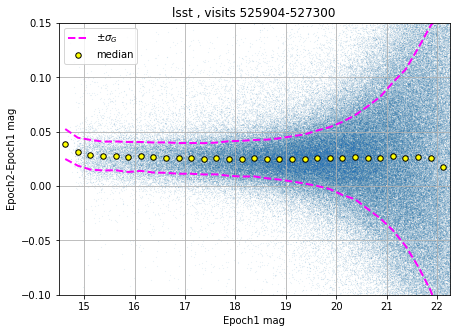

Comparing  525904  to  527300  of  decaps


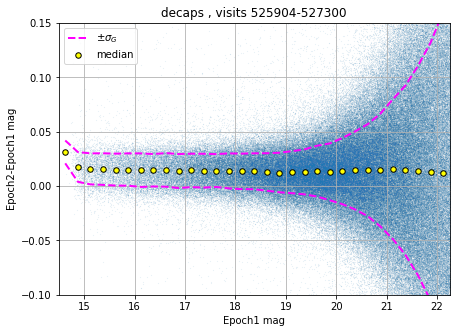

In [5]:
# Read-in cross-matched catalogs from various epochs 
#RMS : LSST_DECAPS comparison of the photometric scatter 

def plot_dmag(cat,ax,bins, source='lsst'):
    #bins = np.arange(14,23,0.5)
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    y = cat[mask_distance][source+'_mag_2']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #fig,ax = plt.subplots(1,1)
    ax.scatter(x,y-x,s=0.001, label='')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(-0.1, 0.15)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('Epoch1 mag')
    ax.set_ylabel('Epoch2-Epoch1 mag')
    ax.grid()
    #ax.set_title(str(visit))
    #plt.savefig(str(visit)+'_half_arcsec_matches1.png', bbox_inches='tight')
    #plt.show()
%matplotlib inline    
bins = np.arange(14.5,22.5,0.25)
for pair in pairs[:1] : 
    print(pairs)
    visit1,visit2 = pair[0], pair[1]
    for source in ['lsst','decaps']:
        print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        fig,ax= plt.subplots(1,1,figsize=(7,5))
        plot_dmag(cat,ax,bins, source=source)
        ax.set_title( source+' , visits '+str(visit1)+'-'+str(visit2))
        fname = source+'-'+source+str(visit1)+'-'+str(visit2) + '_dmag.png'
        plt.savefig( fname , bbox_inches='tight')
        plt.show()
# We positionally cross match DECAPS and LSST catalogs, and plot the 
# magnitude difference for objects within 0.5 arcsec from each other. 
# The median and sigmaG are calculated on full sample, i.e. 
# no clip on magnitude difference. 

# For completeness we also assumed that a match has to be within 
# 0.5 magnitude , but this does not affect median and sigmaG 
# which are not sensitive to rare outliers (objects 
# that are spatially close, but have a magnitude difference larger 
# than 0.5 magnitudes  )

## Multipanel plot of spread in magnitude difference between epochs 

First, create a column with mean LSST-DECAPS source count per visit pair : 

In [3]:
# This has the info about all visits,
# including the number of sources that LSST 
# detected 

# one row per visit 
#visits_table_lsst = Table.read('visits_table_lsst_NEW1.txt', format='latex')

#visit_tables = {}
#for source in ['lsst','decaps']:
#    visit_tables[source] = Table.read('visits_table_'+source+'_NEW.txt', 
#                                      format='ascii')

# read in the joint table with both LSST and DECAPS information 
# on all counts ...
#visit_table = Table.read('decaps_lsst_visit_info.txt', format='ascii')

In [4]:
from astropy.table import Table
# generic info for all visits 
visit_table = Table.read('decaps_lsst_visit_info.txt', format='ascii')

# one row per pair 
chosen_visits = Table.read('decaps_visits_epoch12.txt', format='latex')

chosen_visits['N1'] = 0
chosen_visits['N2'] = 0 
i = 0 
for visit in chosen_visits['visit_1'] : 
    row = visit_table['visit']  == visit 
    N = visit_table['mean_N_per_sq_deg'][row]
    chosen_visits['N1'][i] = N
    i += 1 
i = 0 
for visit in chosen_visits['visit_2'] : 
    row = visit_table['visit']  == visit 
    N = visit_table['mean_N_per_sq_deg'][row]
    chosen_visits['N2'][i] = N
    i += 1 

In [6]:
chosen_visits['meanN'] =(chosen_visits['N1']+ chosen_visits['N2'])/2.0
chosen_visits.sort('meanN')
chosen_visits.write('decaps_visits_epoch12_more.txt', format='ascii')

Now make a combined plot of rms for LSST-LSST,  and a separate plot of rms for DECAPS-DECAPS 

In [ ]:
# calculate the spread : sigmaG
%matplotlib inline
import matplotlib
import matplotlib.lines as mlines
def plot_dmag_epoch_stats(cat,ax,bins, density,color,marker,source='lsst'):
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    y = cat[mask_distance][source+'_mag_2']
    dm = y-x 
    e1 = cat[mask_distance][source+'_magerr_1']
    e2 = cat[mask_distance][source+'_magerr_2']
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # calculate median error 
    median_error1 = bs(x,e1, bins=bins, statistic='median')
    median_error2 = bs(x,e2, bins=bins, statistic='median')
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting  median dmag 
    ax[0].plot(bin_centers , med, label=density, marker=marker, c=color)
    
    # plotting sigma dmag 
    ax[1].plot(bin_centers,sig,label=density,marker=marker, c=color)
    
    # plotting median error 
    ax[2].plot(bin_centers, median_error1.statistic, 
               label=density, marker=marker, c=color, ls='--')
    ax[2].plot(bin_centers, median_error2.statistic, 
               label=density, marker=marker, c=color, ls='-.')
    
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = matplotlib.cm.get_cmap('jet')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
N = len(densities)
colors = (np.arange(len(densities))+1)/N

bins = np.arange(14.5,22.5,0.25)

for source in ['lsst','decaps']:
    # Plot all densities for given processing center on one panel : 
    fig, ax=  plt.subplots(3,1, figsize=(8,12))
    bins = np.arange(14,24,0.5)
    j = 0 
    for pair in pairs : 
        #print(pairs)
        visit1,visit2 = pair[0], pair[1]
        print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        density = densities[j]
        color = cmap(colors[densities == density][0])

        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        
        marker = markers[j]
        plot_dmag_epoch_stats(cat,ax,bins, density,color,marker,source)
        j += 1 
        
    if source is 'lsst' : 
        title = 'LSST'
    else: 
        title = 'DECAPS'

    ax[0].set_title(title+'-'+title)

    ax[0].set_ylabel('median'+r'$ (\Delta m)$'+' [mag]')
    ax[0].set_ylim(-0.08, 0.05)

    ax[1].set_ylabel(r'$\sigma_{G} (\Delta m)$ [mag]')
    ax[1].set_ylim(-0.001,0.1)

    #ax[2].set_ylabel('rms [mag]')
    #ax[2].set_ylim(-0.01,0.25)

    ax[2].set_ylabel('median err [mag]')
    ax[2].set_ylim(-0.001,0.2)
    
    ax[2].set_xlabel(title+' epoch1 [mag]')

    # put the legend outside the plot 
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    for i in range(len(ax)):
        ax[i].grid()

    #ax[1].legend(handles = ax_legend_handles,
    #             bbox_to_anchor=(0.31,0.5),
    #              fancybox=True, loc="center left")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(densities), 
                                                      vmax=max(densities)))
    sm._A = []
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in ax.flat],
                                          aspect=50)
    plt.colorbar(sm, cax=cax,
                 label='N sources per sq.degree') 

    plt.savefig(source+'-'+source+'_spread_plot_N_real_lims.png', bbox_inches='tight')



Make a figure that enables direct comparison of DECAPS-LSST,  DECAPS-DECAPS, LSST-LSST  photometric spread : plot the $\sigma_{G}(\Delta m)$ as a function of magnitude for each of the fields that have a pair...   

In [ ]:
#chosen_visits

We would  do  DECAPS-DECAPS,  LSST-LSST  on visit_1  vs visit_2,  
and plot DECAPS-LSST  on visit_1. So in total we could have 8 plots ( one for 
each visit1 in the chosen_visits above) 

In [ ]:
#chosen_visits

In [ ]:
#np.arange(3+1)/4

Comparing  525846  to  530012  of  decaps
lsst 0
decaps 1
decaps-lsst 2


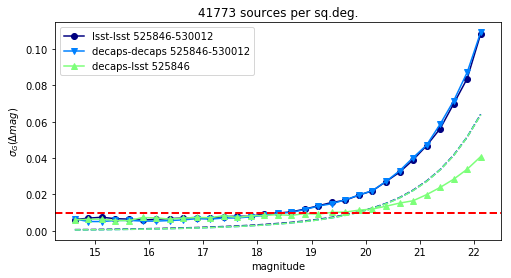

Comparing  525900  to  529989  of  decaps
lsst 0
decaps 1
decaps-lsst 2


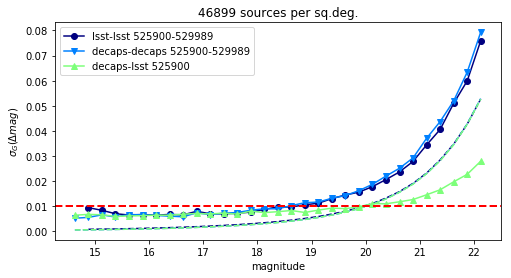

Comparing  525814  to  529974  of  decaps
lsst 0
decaps 1
decaps-lsst 2


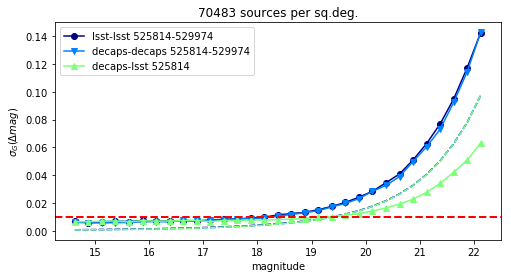

Comparing  525838  to  527247  of  decaps
lsst 0
decaps 1
decaps-lsst 2


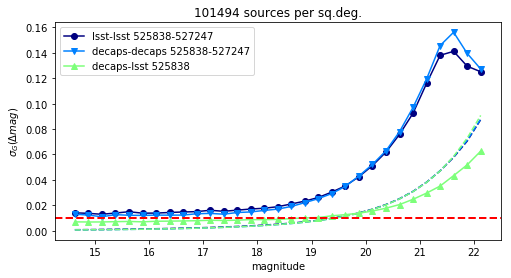

Comparing  525837  to  527246  of  decaps
lsst 0
decaps 1
decaps-lsst 2


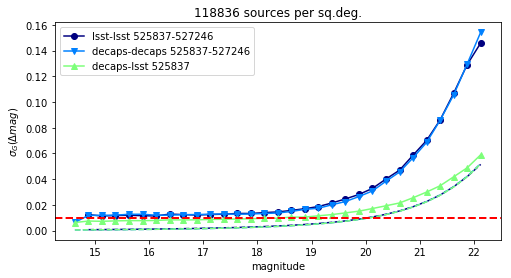

Comparing  525920  to  527296  of  decaps
lsst 0
decaps 1
decaps-lsst 2


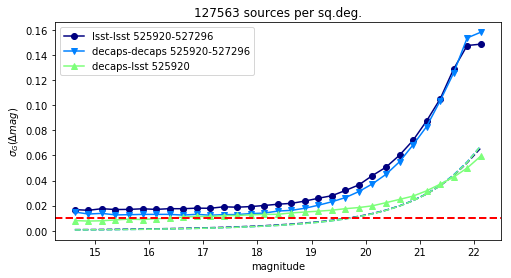

Comparing  525904  to  527300  of  decaps
lsst 0
decaps 1
decaps-lsst 2


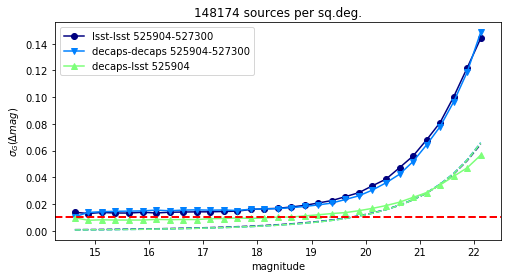

Comparing  525879  to  530032  of  decaps
lsst 0
decaps 1
decaps-lsst 2


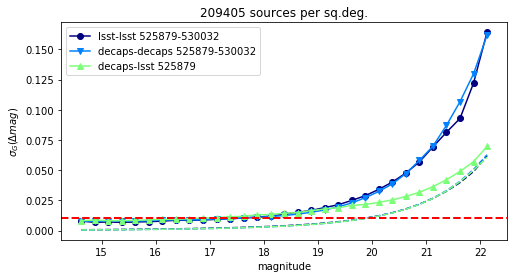

In [12]:
import matplotlib.cm as cm
pairs = [[chosen_visits['visit_1'][i],chosen_visits['visit_2'][i]] 
         for i in range(len(chosen_visits))]
    
cmap = cm.get_cmap('jet')
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = chosen_visits['meanN']
N = len(densities)
colors = np.arange(3+1)/4

bins = np.arange(14.5,22.5,0.25)
bin_centers = (bins[:-1] + bins[1:])/2

k = 0 
for pair in pairs :
    #print(pairs)
    visit1,visit2 = pair[0], pair[1]
    print('Comparing ', visit1, ' to ', visit2, ' of ', source )
    density = densities[k]
        
    fig, ax=  plt.subplots(1,1, figsize=(8,4))   
    j = 0 
    # ADD the sigmaG of LSST-LSST and DECAPS-DECAPS 
    for source in ['lsst','decaps']: 
        print(source,j)
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        marker = markers[j%len(markers)]
        mask_distance = cat['d2darcsec'].data < 0.5
        x = cat[mask_distance][source+'_mag_1']
        y = cat[mask_distance][source+'_mag_2']
        dm = y-x 
        e1 = cat[mask_distance][source+'_magerr_1']
        e2 = cat[mask_distance][source+'_magerr_2']

        color = cmap(colors[j]) 
        
        # calculate the spread : sigmaG 
        spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
        sig = spread_sig.statistic
        
        # calculate the median error 
        median_error1 = bs(x,e1, bins=bins, statistic='median')
        median_error2 = bs(x,e2, bins=bins, statistic='median')
        
        # plot sigmaG with solid lines and markers corresponding
        # to comparison type
        # color corresponds to number of counts 
        ax.plot(bin_centers,sig, 
                label=source+'-'+source+' '+str(visit1)+'-'+str(visit2),
                marker=marker,c=color)
        
        # plot median error for both visits
        ax.plot(bin_centers, median_error1.statistic, ls='--', c=color)
        #ax.plot(bin_centers, median_error2.statistic, ls='-.', c=color)

        j += 1 
        
    #  ADD DECAPS-LSST for visit1   
    print('decaps-lsst',j)
    decaps_lsst = Table.read('decaps-lsst-'+str(visit1)+'.txt', format='ascii')
    mask_distance = decaps_lsst['d2darcsec'].data < 0.5
    x = decaps_lsst[mask_distance]['decaps_mag']
    y = decaps_lsst[mask_distance]['lsst_mag']
    e1 = decaps_lsst[mask_distance]['decaps_magerr']
    e2 = decaps_lsst[mask_distance]['lsst_magerr']
    dm = y-x 
    marker = markers[j%len(markers)] 
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic
    
    # calculate median error 
    median_error1 = bs(x,e1, bins=bins, statistic='median')
    median_error2 = bs(x,e2, bins=bins, statistic='median')
    
    color = cmap(colors[j]) 
    ax.plot(bin_centers,sig, 
            label='decaps-lsst '+str(visit1), 
            marker=marker, c=color)
    ax.plot(bin_centers, median_error1.statistic, c=color, ls='--')
    #ax.plot(bin_centers, median_error2.statistic, c=color, ls='-.')
    ax.set_title(str(int(density)) + ' sources per sq.deg.')
    ax.set_ylabel(r'$\sigma_{G}(\Delta mag)$')
    ax.set_xlabel('magnitude')
    ax.axhline(0.01, ls='--', lw=2, c='red')
    ax.legend()
    
    plt.savefig('photometric_spread_'+str(visit1)+'-'+str(visit2)+'.png',
               bbox_inches='tight')
    plt.show()
    j += 1 
    k += 1 
        
print('Done') 

Above we plot the $\sigma_{G} $ of the magnitude difference between matched sources within 0.5 arcseconds. The dashed blue and red line corresponds to median of  lsst and decaps photometric errors.